In [ ]:
#chargement des bibliothéques
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#charger le dataset
data=pd.read_csv('/content/drive/MyDrive/santé mentale /Formulaire healthy.csv')
data.head()


,Horodateur,Which language would you prefer to use? / Quelle langue préférez-vous utiliser ?,Je consens à l'utilisation anonyme de mes données dans le cadre de ce projet,Êtes-vous actuellement inscrit(e) dans un établissement d'enseignement supérieur ?,Age,Sexe,PHQ-9 (Dépression) [Perte d’intérêt ou de plaisir],"PHQ-9 (Dépression) [Se sentir déprimé(e), découragé(e)]",PHQ-9 (Dépression) [Difficulté à dormir ],PHQ-9 (Dépression) [ Ressentir de la fatigue ],...,How many hours per day do you spend on screens (excluding mandatory online classes)?,Rate the frequency and quality of your social interactions.,Rate the pressure of your current academic workload.,Rate your confidence in facing and overcoming challenges.,Rate your level of stress related to financial difficulties.,Rate the emotional support you receive from your family.,Rate the quality of your relationships with peers and friends.,"Rate the overall quality of your diet (balance, nutrition).","Overall, how would you rate your academic performance during the last semester(GPA)?","Describe your current state of mind and the main challenges you have faced recently (emotional, academic, or personal)."
0,01/12/2025 00:30:15,Français,Oui,Oui,23,Femme,Plus de la moitié du temps (2),Presque tous les jours (3),Plus de la moitié du temps (2),Presque tous les jours (3),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01/12/2025 13:06:09,Français,Oui,Oui,26,homme,Pas du tout (0),Souvent(1),Souvent(1),Souvent(1),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01/12/2025 13:06:16,Français,Oui,Oui,25,homme,Souvent(1),Souvent(1),Fréquemment(2),Souvent(1),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01/12/2025 13:09:34,Français,Oui,Oui,22,homme,Pas du tout (0),Pas du tout (0),Fréquemment(2),Fréquemment(2),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01/12/2025 13:09:54,Français,Oui,Non,28,homme,Souvent(1),Souvent(1),Souvent(1),Fréquemment(2),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data.columns

Index(['Horodateur',
       'Which language would you prefer to use? / Quelle langue préférez-vous utiliser ?',
       'Je consens à l'utilisation anonyme de mes données dans le cadre de ce projet',
       'Êtes-vous actuellement inscrit(e) dans un établissement d'enseignement supérieur ?',
       'Age', 'Sexe', 'PHQ-9 (Dépression)    [Perte d’intérêt ou de plaisir]',
       'PHQ-9 (Dépression)    [Se sentir déprimé(e), découragé(e)]',
       'PHQ-9 (Dépression)    [Difficulté à dormir ]',
       'PHQ-9 (Dépression)    [ Ressentir de la fatigue ]',
       'PHQ-9 (Dépression)    [changements d'appétit]',
       'PHQ-9 (Dépression)    [Se sentir mal vis-à-vis de soi-même]',
       'PHQ-9 (Dépression)    [Difficulté à se concentrer]',
       'PHQ-9 (Dépression)    [Mouvements lents ou agitation excessive]',
       'PHQ-9 (Dépression)    [Pensées de se faire du mal]',
       'PHQ-9 (Dépression)    [Envie de pleurer]',
       'GAD-7 (Anxiété)   [Se sentir nerveux(se) ou à cran]',
       'GA

In [ ]:

# récupérer la colonne avec les comentaires en français
com_fr=data['Décrivez votre état d\'esprit actuel et les principaux défis rencontrés récemment.']
print(com_fr)

0      je suis fatiguée , je me sens seule et la soli...
1                                               Normale 
2                                                    NaN
3                                                  Nada 
4                                                    NaN
                             ...                        
281                                                  NaN
282    Actuellement j’ai un esprit libre, je n’ai plu...
283                                                  NaN
284                                                  NaN
285    Actuellement j’ai un problème d’organisation j...
Name: Décrivez votre état d'esprit actuel et les principaux défis rencontrés récemment., Length: 286, dtype: object


In [ ]:
data.columns
# NETTOYAGE DES NOMS DE COLONNES
# Assurez-vous que le DataFrame de travail est à jour
df = data.copy()

# Supprimer les espaces de début et de fin de TOUS les noms de colonnes
df.columns = df.columns.str.strip()

In [ ]:
#rennomage des colonnes[FR&EN]
# MAPPING BILINGUE COMPLET (FR et EN vers une seule variable cible)
bilingual_map = {
    # Données démographiques
    'Age': ['Age','Age.1'],
    'Sexe': ['Sexe', 'Sex/Gender Identity'],


    # --- Echelles PHQ-9 (Dépression) ---
    'PHQ9_1_Interet': ["  PHQ-9 (Dépression)    [Perte d’intérêt ou de plaisir]", '  PHQ-9 (Dépression)   [Loss of interest or pleasure.]'],
    'PHQ9_2_Humeur': ['  PHQ-9 (Dépression)    [Se sentir déprimé(e), découragé(e)]', '  PHQ-9 (Dépression)   [Feeling down or depressed.]'],
    'PHQ9_3_Sommeil': ['  PHQ-9 (Dépression)    [Difficulté à dormir ]', '  PHQ-9 (Dépression)   [Sleep problems]'],
    'PHQ9_4_Fatigue': ['  PHQ-9 (Dépression)    [ Ressentir de la fatigue ]', '  PHQ-9 (Dépression)   [Feeling tired.]'],
    'PHQ9_5_Appetit': ["  PHQ-9 (Dépression)    [changements d'appétit]", '  PHQ-9 (Dépression)   [Poor appetite or overeating.]'],
    'PHQ9_6_Culpabilite': ['  PHQ-9 (Dépression)    [Se sentir mal vis-à-vis de soi-même]', '  PHQ-9 (Dépression)   [Feeling bad about yourself—or that you are a failure or have let yourself or your family down.]'],
    'PHQ9_7_Concentration': ['  PHQ-9 (Dépression)    [Difficulté à se concentrer]', '  PHQ-9 (Dépression)   [Trouble concentrating on things.]'],
    'PHQ9_8_Agitation': ['  PHQ-9 (Dépression)    [Mouvements lents ou agitation excessive]', '  PHQ-9 (Dépression)   [Moving or speaking so slowly or the opposite]'],
    'PHQ9_9_Suicide': ['  PHQ-9 (Dépression)    [Pensées de se faire du mal]', '  PHQ-9 (Dépression)   [Thoughts that you would be better off dead, or of hurting yourself in some way.]'],

    # --- Echelles GAD-7 (Anxiété) ---
    'GAD7_1_Nerveux': ['  GAD-7 (Anxiété)   [Se sentir nerveux(se) ou à cran]', '   GAD-7 (Anxiéty)   [Feeling nervous or anxious.]'],
    'GAD7_2_Controle': ["  GAD-7 (Anxiété)   [Difficulté à contrôler l’inquiétude]", '   GAD-7 (Anxiéty)   [Worrying too much about different things]'],
    'GAD7_3_Irritable': ["  GAD-7 (Anxiété)   [Être facilement irrité(e) ou agacé(e)]", '   GAD-7 (Anxiéty)   [Becoming easily annoyed or irritable.]'],
    'GAD7_4_Peur': ['  GAD-7 (Anxiété)   [Avoir peur que quelque chose de terrible arrive]', '   GAD-7 (Anxiéty)   [Feeling afraid as if something awful might happen.]'],
    'GAD7_5_Soucis': ["  GAD-7 (Anxiété)   [Trop s’inquiéter à propos de différentes choses]", '   GAD-7 (Anxiéty)   [Having trouble relaxing.]'],

    # --- Facteurs Clés ---
    'Stress_Academique': ['Évaluez la pression de votre charge de travail académique actuelle.  ', 'Rate the pressure of your current academic workload.  '],
    'Stress_Financier': ['Évaluez votre niveau de stress lié aux difficultés financières.', 'Rate your level of stress related to financial difficulties.  '],
    'Soutien_Familial': ['Évaluez le soutien émotionnel que vous recevez de votre famille.  ', 'Rate the emotional support you receive from your family.  '],
    'Soutien_Pairs': ['Évaluez la qualité de vos relations avec vos pairs et ami(e)s.  ', 'Rate the quality of your relationships with peers and friends.  '],
    'Auto_Efficacite': [' Évaluez votre confiance à faire face aux défis et à les surmonter.  ', 'Rate your confidence in facing and overcoming challenges.  '],
    'Performance_Academique': ['Globalement, comment évalueriez-vous vos performances académiques au cours de la dernière session ?  ', 'Overall, how would you rate your academic performance during the last semester(GPA)?'],
    'Texte_Qualitatif': [" Décrivez votre état d'esprit actuel et les principaux défis rencontrés récemment", 'Describe your current state of mind and the main challenges you have faced recently (emotional, academic, or personal).   ']
}

# Colonnes finales à conserver ---
final_cols = list(bilingual_map.keys())
print(final_cols)

['Age', 'Sexe', 'PHQ9_1_Interet', 'PHQ9_2_Humeur', 'PHQ9_3_Sommeil', 'PHQ9_4_Fatigue', 'PHQ9_5_Appetit', 'PHQ9_6_Culpabilite', 'PHQ9_7_Concentration', 'PHQ9_8_Agitation', 'PHQ9_9_Suicide', 'GAD7_1_Nerveux', 'GAD7_2_Controle', 'GAD7_3_Irritable', 'GAD7_4_Peur', 'GAD7_5_Soucis', 'Stress_Academique', 'Stress_Financier', 'Soutien_Familial', 'Soutien_Pairs', 'Auto_Efficacite', 'Performance_Academique', 'Texte_Qualitatif']


In [ ]:
#ajout d'une colonne
bilingual_map_updated = bilingual_map.copy()

bilingual_map_updated['Est_Etudiant'] = [
    'Êtes-vous actuellement inscrit(e) dans un établissement d\'enseignement supérieur ?  ',
    '  Are you currently enrolled in a higher education institution (College, University)?  '
]
final_cols_updated = list(bilingual_map_updated.keys())
print(final_cols_updated)

['Age', 'Sexe', 'PHQ9_1_Interet', 'PHQ9_2_Humeur', 'PHQ9_3_Sommeil', 'PHQ9_4_Fatigue', 'PHQ9_5_Appetit', 'PHQ9_6_Culpabilite', 'PHQ9_7_Concentration', 'PHQ9_8_Agitation', 'PHQ9_9_Suicide', 'GAD7_1_Nerveux', 'GAD7_2_Controle', 'GAD7_3_Irritable', 'GAD7_4_Peur', 'GAD7_5_Soucis', 'Stress_Academique', 'Stress_Financier', 'Soutien_Familial', 'Soutien_Pairs', 'Auto_Efficacite', 'Performance_Academique', 'Texte_Qualitatif', 'Est_Etudiant']


In [ ]:
# Remplacez formulaire_healthy par votre DataFrame
df = data.copy()

# Ensure df columns are stripped, as they should be from previous cells but for robustness
df.columns = df.columns.str.strip()

for final_name, original_cols in bilingual_map_updated.items():
    # Strip the original column names from the map to match the already stripped df.columns
    stripped_original_cols_map = [col.strip() for col in original_cols]

    # Find which of the stripped original column names are actually present in df.columns
    present_cols_in_df = [col for col in stripped_original_cols_map if col in df.columns]

    if len(present_cols_in_df) == 1:
        # If only one matching original column is found
        df[final_name] = df[present_cols_in_df[0]]
    elif len(present_cols_in_df) == 2:
        # If both matching original columns (French and English) are found, merge them
        # We assume the order in bilingual_map_updated is consistent (e.g., French first, then English)
        col_1 = present_cols_in_df[0]
        col_2 = present_cols_in_df[1]
        df[final_name] = df[col_1].fillna(df[col_2])
    else:
        # If no matching original column (stripped) is found in df.columns,
        # create the final column with NaN values to avoid KeyError later.
        df[final_name] = np.nan

# Now, all columns in final_cols_updated should exist in df (either mapped or as NaN)
df_harmonise = df[final_cols_updated].copy()

# --- Étape 3: Filtration (Cruciale) ---

# Détection des valeurs indiquant une inscription
# Vous devez adapter les valeurs de 'OUI' si elles sont différentes dans vos données (Oui, Yes, etc.)
valeurs_etudiant_oui = ['Oui', 'Yes', 'oui', 'yes']

# Filtrer pour ne garder que les étudiants
etudiants_avant_filtre = len(df_harmonise)
df_harmonise = df_harmonise[df_harmonise['Est_Etudiant'].isin(valeurs_etudiant_oui)]
etudiants_apres_filtre = len(df_harmonise)

print(f"Nombre de répondants avant filtration : {etudiants_avant_filtre}")
print(f"Nombre d'étudiants (Après filtre) : {etudiants_apres_filtre}")
print(f"Lignes exclues : {etudiants_avant_filtre - etudiants_apres_filtre}")

# Mise à jour de votre DataFrame de travail
formulaire_healthy = df_harmonise

Nombre de répondants avant filtration : 286
Nombre d'étudiants (Après filtre) : 233
Lignes exclues : 53


In [ ]:
#conversion en numérique
# Conversion des colonnes PHQ/GAD et des facteurs en numérique
phq_gad_factors = [col for col in df_harmonise.columns if col.startswith(('PHQ9_', 'GAD7_')) or col in ['Stress_Academique', 'Stress_Financier', 'Soutien_Familial', 'Soutien_Pairs', 'Auto_Efficacite', 'Performance_Academique']]
# Supprimer les strings et ne garder que le chiffre
import re
def extract_score(value):
    if pd.isna(value):
        return np.nan
    # Chercher le chiffre entre parenthèses, ou si c'est déjà un chiffre seul
    match = re.search(r'\((\d+)\)', str(value))
    if match:
        return int(match.group(1))
    try:
        # Si c'est déjà un chiffre (ex: après une conversion antérieure)
        return float(value)
    except:
        return np.nan

for col in phq_gad_factors:
    df_harmonise[col] = df_harmonise[col].apply(extract_score)

In [ ]:
#calcul du score SDP
phq_items_h = [col for col in df_harmonise.columns if col.startswith('PHQ9_')]
gad_items_h = [col for col in df_harmonise.columns if col.startswith('GAD7_')]

df_harmonise['SDP_Détresse_Psychologique'] = df_harmonise[phq_items_h + gad_items_h].sum(axis=1)
df_harmonise.head()

,Age,Sexe,PHQ9_1_Interet,PHQ9_2_Humeur,PHQ9_3_Sommeil,PHQ9_4_Fatigue,PHQ9_5_Appetit,PHQ9_6_Culpabilite,PHQ9_7_Concentration,PHQ9_8_Agitation,...,GAD7_5_Soucis,Stress_Academique,Stress_Financier,Soutien_Familial,Soutien_Pairs,Auto_Efficacite,Performance_Academique,Texte_Qualitatif,Est_Etudiant,SDP_Détresse_Psychologique
0,23,Femme,2,3,2,3,1,3,1,1,...,1,9.0,7.0,9.0,5.0,7.0,3.0,NaN,Oui,21
1,26,homme,0,1,1,1,1,1,2,0,...,1,9.0,5.0,10.0,8.0,9.0,2.0,NaN,Oui,11
2,25,homme,1,1,2,1,0,1,1,1,...,2,5.0,9.0,10.0,9.0,8.0,3.0,NaN,Oui,13
3,22,homme,0,0,2,2,0,0,0,0,...,2,8.0,7.0,7.0,10.0,10.0,4.0,NaN,Oui,6
5,24,Femme,0,0,1,2,1,0,2,2,...,0,5.0,10.0,7.0,7.0,10.0,4.0,NaN,Oui,10


In [ ]:
df_harmonise.columns

Index(['Age', 'Sexe', 'PHQ9_1_Interet', 'PHQ9_2_Humeur', 'PHQ9_3_Sommeil',
       'PHQ9_4_Fatigue', 'PHQ9_5_Appetit', 'PHQ9_6_Culpabilite',
       'PHQ9_7_Concentration', 'PHQ9_8_Agitation', 'PHQ9_9_Suicide',
       'GAD7_1_Nerveux', 'GAD7_2_Controle', 'GAD7_3_Irritable', 'GAD7_4_Peur',
       'GAD7_5_Soucis', 'Stress_Academique', 'Stress_Financier',
       'Soutien_Familial', 'Soutien_Pairs', 'Auto_Efficacite',
       'Performance_Academique', 'Texte_Qualitatif', 'Est_Etudiant',
       'SDP_Détresse_Psychologique'],
      dtype='object')

In [ ]:
#selection de toutes les colonnes without phq et gad
df_harmonisee = df_harmonise[['Age','Sexe','Stress_Academique', 'Stress_Financier', 'Soutien_Familial', 'Soutien_Pairs', 'Auto_Efficacite', 'Performance_Academique','SDP_Détresse_Psychologique']]

In [ ]:
df_harmonisee['com_fr']=com_fr

In [ ]:
df_harmonisee.head()

,Age,Sexe,Stress_Academique,Stress_Financier,Soutien_Familial,Soutien_Pairs,Auto_Efficacite,Performance_Academique,SDP_Détresse_Psychologique,com_fr
0,23,Femme,9.0,7.0,9.0,5.0,7.0,3.0,21,"je suis fatiguée , je me sens seule et la soli..."
1,26,homme,9.0,5.0,10.0,8.0,9.0,2.0,11,Normale
2,25,homme,5.0,9.0,10.0,9.0,8.0,3.0,13,NaN
3,22,homme,8.0,7.0,7.0,10.0,10.0,4.0,6,Nada
5,24,Femme,5.0,10.0,7.0,7.0,10.0,4.0,10,J’ai aucun problème Hamdoulh


In [ ]:
df_harmonisee['com_en']=df_harmonise['Texte_Qualitatif']

In [ ]:
# téléchargement des ressources NLTK nécessaires
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab') # Added to download the missing resource

lemmatizer = WordNetLemmatizer()
stop_words_en = set(stopwords.words('english'))
stop_words_fr = set(stopwords.words('french')) # Ajout des stopwords français

# Fonction de Pré-traitement pour l'ANGLAIS
def preprocess_english(text):
    if pd.isna(text) or text is None:
        return ""
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = nltk.word_tokenize(text)
    # Suppression des stop words EN + Lemmatisation EN
    cleaned_tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words_en]
    return " ".join(cleaned_tokens)

# Fonction de Pré-traitement pour le FRANCAIS
def preprocess_french(text):
    if pd.isna(text) or text is None:
        return ""
    text = str(text).lower()
    text = re.sub(r'[^a-zÀ-ÿ\s]', '', text) # Ajout de À-ÿ pour le français
    tokens = nltk.word_tokenize(text)
    # Suppression des stop words FR (pas de lemmatisation ici pour éviter les erreurs EN/FR)
    cleaned_tokens = [w for w in tokens if w not in stop_words_fr]
    return " ".join(cleaned_tokens)

# Nettoyage et Fusion (NÉCESSITE LES NOMS DE COLONNES) ---

df_harmonisee['Texte_FR_Clean'] = df_harmonisee['com_fr'].apply(preprocess_french)
df_harmonisee['Texte_EN_Clean'] = df_harmonisee['com_en'].apply(preprocess_english)

In [ ]:
# Fusion des deux colonnes nettoyées
df_harmonisee['Texte_Combine_Clean'] = df_harmonisee['Texte_FR_Clean'] + " " + df_harmonisee['Texte_EN_Clean']



In [ ]:
# 2éme datset NLp de scrapping reddit
import zipfile
import os
zip_path = "/content/drive/MyDrive/santé mentale /health_text.zip"
extract_path = "/content/data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction terminée ✅")
df_reddit=pd.read_csv("/content/data/depression_dataset_reddit_cleaned.csv")
#exploration phase
print(df_reddit.head())
print(df_reddit.shape)
print(df_reddit.is_depression.value_counts())
# Initialisation du Lemmatizer et des Stop-words
lemmatizer = WordNetLemmatizer()
stop_words_en = set(stopwords.words('english'))
def full_preprocess_text(text):
    if pd.isna(text) or text is None:
        return ""

    text = str(text).lower()

    #  Suppression de la ponctuation et des chiffres
    text = re.sub(r'[^a-z\s]', '', text)

    # Tokenisation
    tokens = nltk.word_tokenize(text)

    #  Suppression des Stop-words et Lémmatisation
    cleaned_tokens = []
    for word in tokens:
        if word not in stop_words_en:
            #  Lémmatisation
            cleaned_tokens.append(lemmatizer.lemmatize(word))

    return " ".join(cleaned_tokens)
#appliquer la fonction à notre text
df_reddit['clean_text_lemmatized'] = df_reddit['clean_text'].apply(full_preprocess_text)

print("Pré-traitement (Nettoyage, Stop-words, Lémmatisation) terminé.")

# Vérification du résultat
print("\n--- Comparaison Texte Original vs. Lémmatisé (5 Exemples) ---")
for i in range(5):
    original = df_reddit['clean_text'].iloc[i]
    lemmatized = df_reddit['clean_text_lemmatized'].iloc[i]
    print(f"Original: {original[:100]}...")
    print(f"Lémmatisé: {lemmatized[:100]}...\n")
# --- 1. Préparation des Données avec la nouvelle colonne ---
X_reddit = df_reddit['clean_text_lemmatized']
y_reddit = df_reddit['is_depression']

# Séparation en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    X_reddit, y_reddit, test_size=0.2, random_state=42, stratify=y_reddit
)

#  Création et Entraînement du Pipeline ---
text_classifier_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', LogisticRegression(random_state=42, solver='liblinear'))
])

print("\nDébut de l'entraînement du modèle Texte Reddit (avec lémmatisation)...")
text_classifier_pipeline.fit(X_train, y_train)
print("Entraînement terminé.")

#  Évaluation du Modèle ---
y_pred = text_classifier_pipeline.predict(X_test)

print("\n--- Rapport de Classification du Modèle Texte Reddit (Lémmatisé) ---")
print(classification_report(y_test, y_pred))

Extraction terminée ✅
                                          clean_text  is_depression
0  we understand that most people who reply immed...              1
1  welcome to r depression s check in post a plac...              1
2  anyone else instead of sleeping more when depr...              1
3  i ve kind of stuffed around a lot in my life d...              1
4  sleep is my greatest and most comforting escap...              1
(7731, 2)
is_depression
0    3900
1    3831
Name: count, dtype: int64
Pré-traitement (Nettoyage, Stop-words, Lémmatisation) terminé.

--- Comparaison Texte Original vs. Lémmatisé (5 Exemples) ---
Original: we understand that most people who reply immediately to an op with an invitation to talk privately m...
Lémmatisé: understand people reply immediately op invitation talk privately mean help type response usually lea...

Original: welcome to r depression s check in post a place to take a moment and share what is going on and how ...
Lémmatisé: welcome r depressio

In [ ]:
#  Génération de la Feature Bimodale (Probabilité de Dépression) ---
X_enquete_text = df_harmonisee['Texte_Combine_Clean'].astype(str)

# Utilisation du pipeline TF-IDF/Logistic Regression entraîné sur Reddit
# Nous récupérons le score de la Classe 1 (Dépression)
probabilities = text_classifier_pipeline.predict_proba(X_enquete_text)
df_harmonisee['Prob_Depression_Reddit_Score'] = probabilities[:, 1]

print("\n--- Création de la Feature Bimodale Terminée (Fusion Multilingue) ---")


--- Création de la Feature Bimodale Terminée (Fusion Multilingue) ---


/tmp/ipython-input-4032311145.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_harmonisee['Prob_Depression_Reddit_Score'] = probabilities[:, 1]


In [ ]:
df_harmonisee.head()

,Age,Sexe,Stress_Academique,Stress_Financier,Soutien_Familial,Soutien_Pairs,Auto_Efficacite,Performance_Academique,SDP_Détresse_Psychologique,com_fr,com_en,Texte_FR_Clean,Texte_EN_Clean,Texte_Combine_Clean,Prob_Depression_Reddit_Score
0,23,Femme,9.0,7.0,9.0,5.0,7.0,3.0,21,"je suis fatiguée , je me sens seule et la soli...",NaN,fatiguée sens seule solitude ronge,,fatiguée sens seule solitude ronge,0.119264
1,26,homme,9.0,5.0,10.0,8.0,9.0,2.0,11,Normale,NaN,normale,,normale,0.104462
2,25,homme,5.0,9.0,10.0,9.0,8.0,3.0,13,NaN,NaN,,,,0.104462
3,22,homme,8.0,7.0,7.0,10.0,10.0,4.0,6,Nada,NaN,nada,,nada,0.104462
5,24,Femme,5.0,10.0,7.0,7.0,10.0,4.0,10,J’ai aucun problème Hamdoulh,NaN,jai aucun problème hamdoulh,,jai aucun problème hamdoulh,0.104462


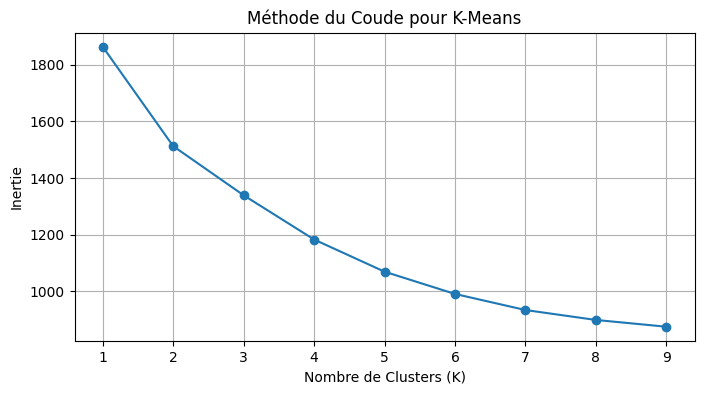

In [ ]:
#etape 4
#application de l'appprentissage non supervisé
#determinons par la méthode coude k
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Variables pour le Clustering sur le Dataset d'Enquête
clustering_features = [
    'Auto_Efficacite',
    'Soutien_Pairs',
    'Stress_Academique',
    'Soutien_Familial',
    'Performance_Academique',
    'Stress_Financier',
    'Prob_Depression_Reddit_Score', # La feature bimodale
    'SDP_Détresse_Psychologique'    # Pour contextualiser le risque
]

# Préparation du DataFrame : on ne garde que les répondants complets (ceux qui ont une valeur dans toutes les features)
df_cluster = df_harmonisee[['Auto_Efficacite','Age','Sexe',
    'Soutien_Pairs',
    'Stress_Academique',
    'Soutien_Familial',
    'Performance_Academique',
    'Stress_Financier',
    'Prob_Depression_Reddit_Score',
    'SDP_Détresse_Psychologique']].dropna(subset=clustering_features).copy()

# Standardisation des données (essentiel pour K-Means)
X_cluster = df_cluster[clustering_features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Méthode du Coude pour trouver K
inertia = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Affichage du coude (ce qui nous intéresse)
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker='o')
plt.title('Méthode du Coude pour K-Means')
plt.xlabel('Nombre de Clusters (K)')
plt.ylabel('Inertie')
plt.grid(True)
plt.show()

# Nous allons ensuite utiliser K=3 ou K=4 si l'analyse visuelle le suggère

In [ ]:
#choix de k=3 car c'est presue le point de fléchissemnt
# Standardisation des données
X_cluster = df_cluster[clustering_features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Application de K-Means avec K=3
K = 3
kmeans_model = KMeans(n_clusters=K, random_state=42, n_init=10)
df_cluster['Cluster_Ref'] = kmeans_model.fit_predict(X_scaled)

# --- Analyse des Profils (Confirmation) ---
print(f"\n--- Analyse des {K} Profils de Référence ---")
profile_analysis = df_cluster.groupby('Cluster_Ref')[clustering_features].mean()
print(profile_analysis)


--- Analyse des 3 Profils de Référence ---
             Auto_Efficacite  Soutien_Pairs  Stress_Academique  \
Cluster_Ref                                                      
0                   3.538462       3.653846           3.807692   
1                   8.192982       8.096491           7.228070   
2                   6.301075       5.956989           7.924731   

             Soutien_Familial  Performance_Academique  Stress_Financier  \
Cluster_Ref                                                               
0                    4.192308                1.730769          3.653846   
1                    8.561404                3.008772          5.701754   
2                    5.698925                2.774194          8.150538   

             Prob_Depression_Reddit_Score  SDP_Détresse_Psychologique  
Cluster_Ref                                                            
0                                0.126647                   14.346154  
1                                

In [ ]:

# etape de l'analyse predictive
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# --- Liste Finale des Features du Pont (Celles qui existent dans le Dataset de Prédiction) ---
bridge_features = [
    'Auto_Efficacite',
    'Soutien_Familial',
    'Stress_Academique',
    'Stress_Financier',
    'Performance_Academique',
    'Soutien_Pairs',
    'Prob_Depression_Reddit_Score', # La feature bimodale
    'SDP_Détresse_Psychologique'
]

# s'assurer que X et y sont propres
X_bridge = df_cluster[bridge_features]
y_bridge = df_cluster['Cluster_Ref']


# Séparation des données
X_train, X_test, y_train, y_test = train_test_split(
    X_bridge, y_bridge, test_size=0.2, random_state=42, stratify=y_bridge
)

# Entraînement du Modèle Pont (Random Forest)
bridge_model = RandomForestClassifier(n_estimators=100, random_state=42)
bridge_model.fit(X_train, y_train)

# Évaluation
y_pred = bridge_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n--- Performance du Modèle Pont (Prédire le Cluster) ---")
print(f"Accuracy de Prédiction du Cluster : {accuracy:.4f}")

# Analyse de l'importance des features du Pont
feature_importance = pd.Series(bridge_model.feature_importances_, index=bridge_features).sort_values(ascending=False)
print("\nImportance des Features dans le Modèle Pont (Ordre d'importance):")
print(feature_importance)


--- Performance du Modèle Pont (Prédire le Cluster) ---
Accuracy de Prédiction du Cluster : 0.8511

Importance des Features dans le Modèle Pont (Ordre d'importance):
Soutien_Pairs                   0.197532
Auto_Efficacite                 0.160381
SDP_Détresse_Psychologique      0.159011
Stress_Financier                0.146270
Soutien_Familial                0.138433
Stress_Academique               0.086888
Prob_Depression_Reddit_Score    0.055919
Performance_Academique          0.055568
dtype: float64


In [ ]:
df_cluster.head()

,Auto_Efficacite,Age,Sexe,Soutien_Pairs,Stress_Academique,Soutien_Familial,Performance_Academique,Stress_Financier,Prob_Depression_Reddit_Score,SDP_Détresse_Psychologique,Cluster_Ref
0,7.0,23,Femme,5.0,9.0,9.0,3.0,7.0,0.119264,21,2
1,9.0,26,homme,8.0,9.0,10.0,2.0,5.0,0.104462,11,1
2,8.0,25,homme,9.0,5.0,10.0,3.0,9.0,0.104462,13,1
3,10.0,22,homme,10.0,8.0,7.0,4.0,7.0,0.104462,6,1
5,10.0,24,Femme,7.0,5.0,7.0,4.0,10.0,0.104462,10,1


<Figure size 800x800 with 0 Axes>

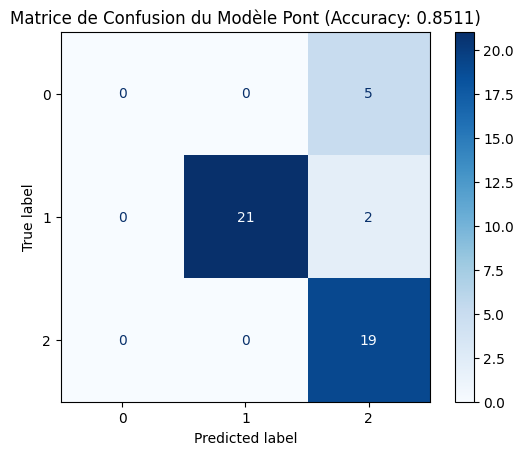


--- Matrice de Confusion (Numérique) ---
[[ 0  0  5]
 [ 0 21  2]
 [ 0  0 19]]

--- Rapport de Classification (Précision, Rappel, F1-Score) ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       1.00      0.91      0.95        23
           2       0.73      1.00      0.84        19

    accuracy                           0.85        47
   macro avg       0.58      0.64      0.60        47
weighted avg       0.78      0.85      0.81        47



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels=bridge_model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=bridge_model.classes_)

plt.figure(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title(f"Matrice de Confusion du Modèle Pont (Accuracy: {bridge_model.score(X_test, y_test):.4f})")
plt.show()

# Affichage des valeurs numériques (plus simple à copier-coller)
print("\n--- Matrice de Confusion (Numérique) ---")
print(cm)

from sklearn.metrics import classification_report
print("\n--- Rapport de Classification (Précision, Rappel, F1-Score) ---")
report = classification_report(y_test, y_pred)
print(report)

In [ ]:
import joblib
# Remplacez 'bridge_model' par l'objet de votre modèle Random Forest final
joblib.dump(bridge_model, 'bridge_model_final.pkl')

['bridge_model_final.pkl']